# Twitter User Archetypes with NLP
_The task: build a Twitter bot that can determine a user’s interest on the fly and serve up a relevant GIF._

## Preparing the Timelines
To start we need a method of collecting and processing timelines, we’ll be using the wonderful [Tweepy](http://www.tweepy.org/) package to query the Twitter API. Below is a simple function for collecting a given Twitter account’s timeline as a list of strings — we do not need the full tweet object for each tweet as we’re only working on with the text.

_NOTE: The Twitter API returns “up to” 200 tweets, because of this it may return fewer than 200 tweets, we want the option to either make only one call (`goal = -1`) or however many calls are required to reach a given number of tweets (`goal = 1000`)._

In [1]:
import tweepy
from time import sleep

import tweepy
from time import sleep

twitter_auth_APP = tweepy.AppAuthHandler(
    '7cBDtVCdARvRuKkWJB6RZ9Nfh',
    'oc0z8Wi0rKXFt2orM5O51FQE90bQlajZ0b5X00CEbu49C2p6aB'
)

API = tweepy.API(twitter_auth_APP)

def getTimeline(handle, exclude_rts = False, exclude_replies = False, goal = -1):
    print("Collecting {}'s timeline".format(handle))
    timeline = []
    max_id = None
    
    while True:
        new_tweets = API.user_timeline(
            handle,
            count = 200,
            tweet_mode = 'extended',
            exclude_replies = exclude_replies,
            include_rts = not exclude_rts,
            max_id = max_id
        )
        
        # check that the call returned tweets
        if (max_id and len(new_tweets) == 1) or len(new_tweets) == 0:
            break
            
        # add the new tweets to the timeline
        timeline += new_tweets[1:]
        # set the max_id for the next call
        max_id = new_tweets[-1].id_str
        
        if goal < 1:
            break
            
        elif len(timeline) >= goal:
            break

    # extract the string from the timeline object
    timeline_as_strings = [tweet.full_text for \
                           tweet in timeline[:goal]]
    
    return timeline_as_strings

Next we need to clean and tokenize each tweet. We’ll remove hashtags (these are usually brand or event specific), at-mentions, numbers, and common words (basic [stop words](https://en.wikipedia.org/wiki/Stop_words) provided by [NLTK](http://www.nltk.org/) and others identified by manually analyzing timelines) that could skew our results. We’ll also separate each tweet into a list of 1-, 2-, and 3-word strings (known as [n-grams](https://en.wikipedia.org/wiki/N-gram)).

_NOTE: Manually analyzing timelines is a pain, the best method I’ve found is to tokenize each timeline then look at the top 10 most common tokens and their frequency for each timeline and add terms to your stop list that are disproportionately frequent._

In [2]:
import re
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from string import digits

stoplist_tw=['get', 'got', 'hey', 'hmm', 'hoo', 'let', 'ooo', 'par',
    'yer', 'didn', 'one', 'com', 'new', 'like', 'great',
    'make', 'top', 'awesome', 'best', 'good', 'wow', 'yes',
    'say', 'yay', 'would', 'thanks', 'thank', 'use',
    'should', 'could','best','really','see','want','nice',
    'while','know', 'trump', 'nyfw', 'iphone', 'hurricane',
    'rt', 'per', 'espn', 'soundcloud', 'ten', 'count', 
    'advance', 'newsletter','thedish', 'nycwff', 'thefword',
    'irma', 'fave', 'beer', 'stefan', 'aiga',
    'aigatogether', 'aigadesignconf', 'aigadg', 'aigagala',
    'ddc', 'tbt', 'whitneybiennial', 'calder', 'wknd',
    'pipilottirist', 'live', 'watch', 'check', 'video',
    'clip', 'today', 'tonight', 'week', 'year', 'month',
    'time', 'last', 'night', 'morning', 'yesterday',
    'tomorrow', 'day', 'first', 'love', 'nyc', 'city',
    'york', 'new', 'happy', 'need', 'look', 'back', 'right',
    'win', 'chance', 'enter', 'ever','pst','wha','yep', 'via',
    'app', 'twitter', 'streaming', 'stream', 'ask', 'amp',
    'beautiful', 'best', 'amazing', 'good', 'perfect', 'cute',
    'simple', 'love'
]
stoplist = set(stopwords.words('english') + stoplist_tw)
tokenizer = RegexpTokenizer(r'\w+')

def tokenize(document, max_n_grams = 3, min_word_length = 3):
    # removes hashtags, at-mentions, and links
    document = re.sub(
        r"(?:#|\@|https?\:\/\/|www\.)\S+",
        "",
        document
    )
    
    tokens = tokenizer.tokenize(document.lower())
    
    # remove tokens that are shorter than the min_word_length
    # remove tokens that contain numbers
    # remove stop words
    tokens = [token for token in tokens
        if (len(token) >= min_word_length) and
        (len(token.strip(digits)) == len(token)) and
        (token not in stoplist)
    ]
    
    # collect n_grams up to the max_n_gram size
    token_grams = []
    if (max_n_grams > 1):
        for n in range(2, max_n_grams + 1):
            for start, token in enumerate(tokens[:-1*(n-1)]):
                gram = ''
                end = start + n
                for token in tokens[start:end]:
                    gram += ' ' + token
                    
                token_grams.append(gram.strip())
                
    return tokens + token_grams

I used a JSON file to load in the prototypes for each archetype with a field declaring whether to include or exclude retweets (I found these were sometimes noisy). This file had the following format:
```
[
    {
        "handle": "<HANDLE>",
        "category": "<CATEGORY>",
        "exclude_rts": <true OR false>
    },
    ...
    {
        "handle": "<HANDLE>",
        "category": "<CATEGORY>",
        "exclude_rts": <true OR false>
    }
]
```
Finally, we gather 2000 tweets from each prototypical account, excluding replies as these are brands and replies are largely used for customer service:

In [3]:
import json
ground_truth_file = 'ground_truth.json'
ground_truth = None
with open(ground_truth_file, 'r') as data:
     ground_truth = json.loads(data.read())

timelines = []
categories = []
handles = []
for user in ground_truth:
    # store categories and handles for later
    categories.append(user['category'])
    handles.append(user['handle'])
    
    timeline = getTimeline(
        user['handle'],
        user['exclude_rts'],
        True, # exclude noisy replies
        2000
    )
    
    tokenized_timeline = [tokenize(tweet) for tweet in timeline]
    timelines.append(tokenized_timeline)

del ground_truth

## Building the Topic Model
Now that we have each timeline we can start training the topic model. When I was first working on this project, I tried training the model with each timeline as a document. I found that, given the lack of actual paragraphs on Twitter this was far too noisy. Instead, I trained the model with each individual tweet as a document. This tightened the topics substantially.

We’ll be using the Gensim package for the topic modeling. We start by converting the tweets to a bag-of-words corpus to simplify each tweet to a vector representation of word IDs and their respective frequency: `[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1)]`. In this step we can also trim out words that are both too frequent (present in greater than 5% of all tweets) and too infrequent (present in fewer than 5 tweets). To ensure that we are properly weighting words despite all our cleaning, we apply a [term frequency-inverse document frequency (tf-idf)](https://radimrehurek.com/gensim/models/tfidfmodel.html) transformation to our corpus. Given the size of our documents (140 characters or fewer at the time), the tf-idf transformation won’t alter our training data much, but will be wildly helpful when running the model on the full timelines. Finally, we train our topic model. In this case I created a [latent semantic indexing (LSI)](https://radimrehurek.com/gensim/models/lsimodel.html) model — more often referred to as latent semantic analysis (LSA). LSI/LSA is a method of dimensionality reduction that uses [singular-value decomposition](https://en.wikipedia.org/wiki/Singular-value_decomposition) to group words into topics, the basic assumption behind this is that similar words appear in similar documents. Unfortunately the method of determining the number of topics is often a process of trial and error involving analyzing the words in sample topics to verify that they make sense, I ended up using 40 topics.

In [4]:
from gensim import corpora
from gensim.models.tfidfmodel import TfidfModel
from gensim.models.lsimodel import LsiModel

all_tweets = []
for timeline in timelines:
    all_tweets.extend(timeline)

dictionary = corpora.Dictionary(all_tweets)
# filter out any terms only present in fewer than 5 tweets
# or present in greater than 5% of all tweets
dictionary.filter_extremes(no_below = 5, no_above = 0.05)
dictionary.compactify()
# convert tweets to bag of words
corpus = [dictionary.doc2bow(tweet) for tweet in all_tweets]

# train the tfidf model
tfidf = TfidfModel(corpus)

# train the LSI/LSA model
lsi = LsiModel(
    corpus = tfidf[corpus],
    id2word = dictionary,
    num_topics = 40
)

We can now easily build an LSI vector representation of each timeline using the topic model. While we trained the model on each individual tweet we will be vectorizing each timeline as a single document.

In [7]:
timeline_vectors = []
for i, timeline in enumerate(timelines):
    # string together all tweets in each timeline
    timeline_flat = [token for tweet in timeline \
                     for token in tweet]
    # convert to bag of words
    timeline_bow = dictionary.doc2bow(timeline_flat)
    timeline_vector = lsi[tfidf[timeline_bow]]
    timeline_vectors.append(timeline_vector)

We can visualize these vectors using [principal component analysis (PCA)](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) via [scikit-learn](http://scikit-learn.org/stable/) and [matplotlib](https://matplotlib.org/). Gensim outputs its vectors (list of tuples) differently than scikit-learn (NumPy array) so we need to convert them for cross-use.

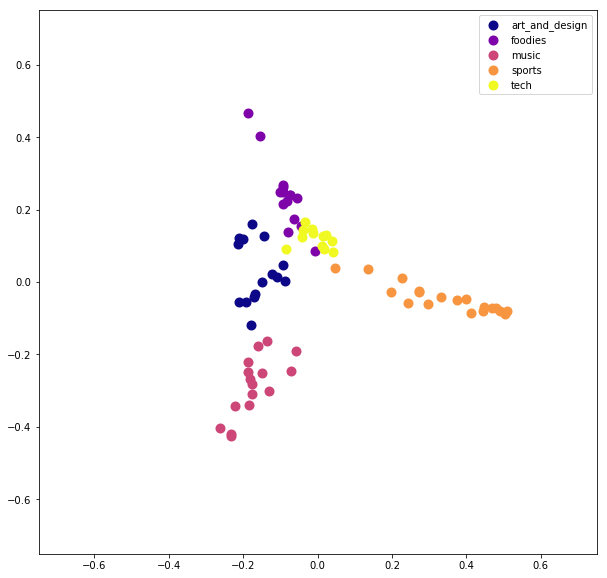

In [8]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import numpy as np

# converts a list of tuples to a dense NumPy array
def tuples_array(tuples_vector, length):
    arr = [0.0 for _ in range(length)]
    for col, val in tuples_vector:
        arr[col] = val
    return np.array(arr)

# convert text labels to ids
encoder = LabelEncoder()
categories_encoded = encoder.fit_transform(categories)

timeline_arrays = np.array([tuples_array(vector, lsi.num_topics) for \
                   vector in timeline_vectors])
labels = encoder.classes_

pca = PCA(n_components = 40)
X_pca = pca.fit(timeline_arrays).transform(timeline_arrays)

plt.figure(figsize = (10,10))
#cmap = plt.get_cmap('tab20b_r')
cmap = plt.get_cmap('plasma')
colors = cmap(np.linspace(0,1,len(encoder.classes_)))

for color, i, label in zip(colors, range(len(encoder.classes_)), \
                           encoder.classes_):
    plt.scatter(
        X_pca[categories_encoded == i, 0],
        X_pca[categories_encoded == i, 1],
        color = color,
        alpha = 1,
        lw = 4,
        label = label
    )
    
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.ylim(-0.75, 0.75)
plt.xlim(-0.75, 0.75)
plt.show()

## Building the Categorization Model
We have topic vectors for every account in each category and we can see that even at two dimensions these categories are distinct. We can now use these vectors to build a model to categorize new users based on their topic distribution. For our categorization algorithm we’ll use [k-nearest neighbors](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html), to compare each new timeline to our prototypes. We’ll use [cosine similarity](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.spatial.distance.cosine.html), because it looks at the angle between any two vectors, this way it compares orientation of the vectors agnostic of magnitude. We’ll then use [cross-validated grid search](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) to test out some options for the number of neighbors (k) and the weighting of each of those neighbors.

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from scipy.spatial.distance import cosine
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_neighbors': range(5, 20),
    'weights': ['uniform', 'distance'],
    'metric': [cosine]
}
neigh = KNeighborsClassifier()
grid_search = GridSearchCV(neigh, param_grid, cv = 10)
grid_search.fit(timeline_arrays, categories_encoded)

In [ ]:
import json
testing_file = 'testing.json'
tsting_data = None
with open(testing_file, 'r') as data:
     tsting_data = json.loads(data.read())

test_timelines = []
test_categories = []
test_handles = []
for user in tsting_data:
    test_categories.append(user['category'])
    test_handles.append(user['handle'])
    
    timeline = getTimeline(user['handle']
    
    tokenized_timeline = [tokenize(tweet) for tweet in timeline]
    test_timelines.append(tokenized_timeline)

We’ll format this for the model and get an accuracy sore.

In [ ]:
test_vectors = []
for timeline in test_timelines:
    all_tokens = [token for tweet in timeline for token in tweet]
    test_vectors.append(lsi[tfidf[dictionary.doc2bow(all_tokens)]])
test_arrays = np.array([tuples_array(vector, lsi.num_topics) for vector in test_vectors])
test_categories_encoded = encoder.transform(test_categories)

grid_search.score(test_arrays, test_categories_encoded)

I ended up with an accuracy of ~75%! Finally let’s save our model to disk and build the bot. We’ll use the ever-handy [joblib](https://pythonhosted.org/joblib/) pickler as well as Gensim’s built in serialization methods.

In [ ]:
import os
import joblib

# save model
# create the model directory if it doesn't exist
if not os.path.exists('model'):
    os.makedirs('model')
dictionary.save('model/dictionary.pkl')
tfidf.save('model/tfidf.pkl')
lsi.save('model/lsi.pkl')
joblib.dump(encoder, 'model/encoder.pkl')
joblib.dump(grid_search, 'model/grid_search.pkl')

# load model
# dictionary = corpora.Dictionary.load('model/dictionary.pkl')
# tfidf = TfidfModel.load('model/tfidf.pkl')
# lsi = LsiModel.load('model/lsi.pkl')
# encoder = joblib.load('model/encoder.pkl')
# grid_search = joblib.load('model/grid_search.pkl')

## A Judgmental (But Never Temperamental) Twitter Bot
This Twitter bot will need to reply to users so we’ll need to set up a user auth. This time we'll need a Twitter user access token and access token secret. We’ll be sourcing our GIFs from [GIPHY](https://giphy.com/) for this proof of concept, in execution we would use custom assets and copy, so add in your [GIPHY API](https://developers.giphy.com/) key.

In [ ]:
GIPHY_KEY = '<GIPHY_KEY>'
twitterAuth_USER = tweepy.OAuthHandler(
    '<CONSUMER_KEY>',
    '<CONSUMER_SECRET>'
)
twitterAuth_USER.set_access_token(
    '<ACCESS_TOKEN>',
    '<ACCESS_TOKEN_SECRET>'
)
twitterAPI_USER = tweepy.API(twitterAuth_USER)

First, let’s create a function that will take a user handle as input and output their archetype.

In [ ]:
from tweepy import TweepError

def checkUser(handle):
    # try to collect the timeline
    try:
        timeline = getTimeline(handle)
    except TweepError as e:
        return False
    
    # tokenize the timeline
    tokens = []
    for tweet in timeline:
        tokens.extend(tokenize(tweet))
        
    # convert to a bag of words
    bow = dictionary.doc2bow(tokens)
    
    # vectorize the timeline
    vector = lsi[tfidf[bow]]
    array = tuples_array(vector, lsi.num_topics)
    
    # return the matching result
    return encoder.classes_[grid_search.predict([array])[0]]

Let’s set up the function that will reply to a given tweet, we’ll use [requests](http://docs.python-requests.org/en/master/) to make our GIPHY API calls and Tweepy to send the reply. We’ll be using the [random endpoint](https://developers.giphy.com/docs/#operation--gifs-random-get) to pull a GIF tagged with our archetype.

In [ ]:
import requests

def sendGIF(tweet):
    print("Replying to the tweet")
    handle = tweet.user.screen_name
    archetype = checkUser(handle)

    try:
        # request a random GIF relevant to the archetype
        data = requests.get("http://api.giphy.com/v1/gifs/random?api_key={}&tag={}".format(GIPHY_KEY, archetype))
        if data.status_code == 200:
            # send a Twitter reply with a link to the GIF
            gif = data.json()['data']['image_url']
            reply = twitterAPI_USER.update_status(
                "@{} {}".format(handle, gif),
                in_reply_to_status_id = tweet.id_str
            )
            print("http://www.twitter.com/{}/status/{}".format(reply.user.screen_name, reply.id))

        else:
            print("GIPHY has failed us")

    except tweepy.TweepError as e:

        if (str(e).lower().find('is a duplicate')):
            print("Reply already sent")

Twitter allows us to listen to a [stream of content filtered around specific keywords](https://developer.twitter.com/en/docs/tweets/filter-realtime/overview), be those hashtags, at-mentions, or otherwise. Provided that your bot is not receiving super-bowl level engagement, this endpoint should catch everything. We can access this endpoint through Tweepy which uses a StreamListener class to handle incoming tweets, we’ll create a subclass of this listener to add our own tweet handling functions. We’ll put each incoming tweet into a [queue](https://docs.python.org/2/library/queue.html) so that our listener doesn’t get backed up and handle each tweet in a separate thread in the order they were received.

In [ ]:
import six
if six.PY3:
    from queue import Queue
else:
    from Queue import Queue
import threading

class BotListener(tweepy.StreamListener):
    
    def __init__(self, handler):
        # initialize the queue and handler functions
        self.q = Queue()
        self.handler = handler
        # start the thread for the queue
        thread = threading.Thread(target=self.handleQueue)
        thread.setDaemon(True)
        thread.start()
        # initialize the parent class
        tweepy.StreamListener.__init__(self)
    
    def handleQueue(self):
        # an endless loop that runs in a separate thread
        while True:
            # sends each tweet object to the handler function
            tweet = self.q.get()
            self.handler(tweet)
            self.q.task_done()

    def on_status(self, tweet):
        # add tweet to the queue
        self.q.put(tweet)

Finally, let’s start the bot listening around the hashtag _#MyArchetypeBot_.

In [ ]:
listener = BotListener(sendGIF)
stream = tweepy.Stream(auth = twitterAuth_USER, listener = listener)
stream.filter(track = ["#MyArchetypeBot"])

There you have it! Now when the bot notices a tweet with the given hashtag it will collect the user’s timeline and respond with a link to a GIF relevant to the user’s interests.